## Поиск негативных комментариев

### План

<a href='#section1'>1. Подготовка</a>

<a href='#section2'>2. Обучение</a>

<a href='#section3'>3. Выводы</a>

<a id='section1'></a>
# Подготовка

In [1]:
import pandas as pd
import re 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords 
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import f1_score
import warnings
nltk.download('wordnet')
nltk.download('stopwords')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [3]:
%%time

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w) for w in word_list])


# приводим весь текст к нижнему регистру и оставляем только английский текст с пробелами
df['text'] = df['text'].str.lower().apply(lambda x: re.sub(r'[^a-z ]', ' ', x))
# разделяем на слова
df['text'] = df['text'].apply(lambda x: " ".join(x.split()))
df['text'] = df['text'].apply(lemmatize)

df = df.drop_duplicates()
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158265 entries, 0 to 159570
Data columns (total 2 columns):
text     158265 non-null object
toxic    158265 non-null int64
dtypes: int64(1), object(1)
memory usage: 3.6+ MB
CPU times: user 2min 7s, sys: 956 ms, total: 2min 8s
Wall time: 2min 10s


,text,toxic
0,explanation why the edits made under my userna...,0
1,d aww he match this background colour i m seem...,0
2,hey man i m really not trying to edit war it s...,0
3,more i can t make any real suggestion on impro...,0
4,you sir are my hero any chance you remember wh...,0


Позитивных комментариев больше в 8.8 раз
0 - позитивные комментарии, 1 - негативные


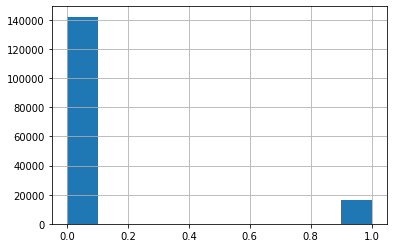

In [4]:
print('Позитивных комментариев больше в', 
      round(df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1], 1), 'раз')
print('0 - позитивные комментарии, 1 - негативные')
df['toxic'].hist()

Исходный набор данных содержит почти 160 тысяч строк, удалили дубликаты, которые образовались после преобразований - примерно 1300 строк. Количество положительных комментариев почти в 9 раз больше, чем негативных.

<a id='section2'></a>
# Обучение

In [5]:
# отделяем целевой признак
features = df['text']
target = df['toxic']
# разделяем данные на выборки в соотношении 3:1
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size = 0.25, random_state = 12345)

# векторизируем текст с учётом стоп-слов
stop_words = set(stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words = stop_words)
train = count_tf_idf.fit_transform(features_train)
test = count_tf_idf.transform(features_test)
print("Размеры матриц для выборок:")
print("Обучающая - ", train.shape)
print("Тестовая - ", test.shape)

Размеры матриц для выборок:
Обучающая -  (118698, 134049)
Тестовая -  (39567, 134049)


In [6]:
model = LogisticRegression(random_state=12345, class_weight='balanced')
model.fit(train, target_train)
predictions = model.predict(test)
f1 = f1_score(target_test, predictions)
print("F1 модели логистической регрессии:", round(f1, 2))

F1 модели логистической регрессии: 0.75


In [7]:
model = SGDClassifier(random_state=111, penalty='none')
model.fit(train, target_train)
predictions = model.predict(test)
f1 = f1_score(target_test, predictions)
print("F1 модели SGDClassifier:", round(f1, 2))

F1 модели SGDClassifier: 0.78


Обе исследуемые модели подходят для решения задачи, т.к. значение метрики качества F1 не меньше 0.75

<a id='section3'></a>
# Выводы

В качестве предобработки мы очистили текст от всех символов кроме английских букв и пробелов, перевели в нижный регистр для упрощения, лемматизировали комментарии и удалили дубликаты.

Данные поделили на обучающую и тестовую выборки, перед обучением моделей преобразовали текст в матрицу, очистили от стоп слов.

Обучили две модели - логистическую регрессию и SGDClassifier. Лучший результат метрики качества F1 0.78 показала модель SGDClassifier, с помощью логистической регрессии удалось достичь значения F1 равное 0.75.